In [1]:
!pip install fugashi[unidic-lite]
!pip install unidic
!python -m unidic download
!pip install wordcloud
!pip install demoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.7/671.7 kB 16.1 MB/s eta 0:00:00
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=ee4d9fdbd659ad462218490194ca0a9d1983307a8c9ff52f3eb40c99f5887644
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite
  Preparing metadata (setup.py) ... done
  Created wheel for unidic: filename=unidic-1.1.0-py3-none-any.whl size=7403 sha256=9d8cf7a347ca1133b2321a792d56d8fd3e76d7b0dc3aa79cc7b3016e85d1a442
  Stored in directory: /root/.cache/pip/wheels/7a/72/72/1f3d654c345ea69d5d51b531c90daf7ba14cc555eaf2c64ab0
Successfully built unidic
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.3
    Uninstalling wasabi-1.1.3:
      Successfully uninstalled wasabi-1.1.3
download url: https:/

In [2]:
!wget https://github.com/watson-developer-cloud/doc-tutorial-downloads/raw/refs/heads/master/discovery-data/custom_stopwords_ja.json

--2024-11-29 06:53:45--  https://github.com/watson-developer-cloud/doc-tutorial-downloads/raw/refs/heads/master/discovery-data/custom_stopwords_ja.json
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/watson-developer-cloud/doc-tutorial-downloads/refs/heads/master/discovery-data/custom_stopwords_ja.json [following]
--2024-11-29 06:53:45--  https://raw.githubusercontent.com/watson-developer-cloud/doc-tutorial-downloads/refs/heads/master/discovery-data/custom_stopwords_ja.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1371 (1.3K) [text/plain]
Saving to: ‘custom_stopwords_ja.json’

custom_stop

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud

import string
from fugashi import Tagger
import unidic
from pathlib import Path
import json
import codecs
import demoji
import re
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pattern = string.punctuation + "、。／＠＋＊＜＞・？￥＿＝｜～！”＃＄％＆’（）「」『』【】()"
with open("custom_stopwords_ja.json", mode='r') as f:
  jsondata = json.loads(f.read())
  stopwords = jsondata['stopwords']

tagger = Tagger(f"{unidic.DICDIR}")

In [12]:
#データをDataFrame形式で読み込み

with codecs.open("Y210168@20241128.csv", "r", "shift-jis", "ignore") as f:
  df = pd.read_table(f, delimiter=',')

print(df.shape)
df.head(10)

(904, 3)


,コメント,判断ラベル,Unnamed: 2
0,このスニーカー何か分かる方いますか！本日開催するSLS Tokyoで堀米が履いてるスニーカー...,0,110001
1,人が履いてるDunkって、めちゃくちゃかっこよく見えて欲しくなるいざ自分が履いて上から見ると...,1,110002
2,同封したい関係でコメント頂ければ多少お安くします！気になる方はコメントください。,1,110003
3,NIKEのタイトブースとパンダダンクで迷ってます笑笑みなさんはどちらかがおすすめしますか？あ...,0,110004
4,格安にて出品中です。即購入○よろしくお願いします。,1,110005
5,堀米ダンクは普段のSBダンクとサイズ感が違うらしいので、持っている方サイズ感教えて頂きたいで...,0,110006
6,普段25cmのdunkを履いていてほんの少しでかいぐらいなんですが堀米の26cmを買ってしま...,2,110007
7,今日も天気が良くて過ごしやすい??そんな足元はクラシックグリーン??カラーリングが良くて合わ...,2,110008
8,ご希望に添えるかは分かりませんが、値引きも考えてます。よろしくお願いします,1,110009
9,??堀米さん??履いて、小学校まで模擬登校??今日は、来年1年生になる長男と再来年1年生にな...,1,110010


In [13]:
#各ラベルのデータ数を表示
df.判断ラベル.value_counts()

,count
判断ラベル,
1,604
2,186
0,114


In [14]:
def preprocess(text):
  result_text = ""
  text = re.sub(r"[{}]".format(pattern), "", text)
  text = re.sub("[0-9]+", "", text)
  text = text.lower()
  text = demoji.replace(text, repl="")
  words = tagger(text)
  for word in words:
    if word.feature.lemma not in stopwords and word.feature.pos1 in ["動詞", "名詞", "形容詞", "形容動詞"]:
      if re.match("[a-z]+", word.surface) or word.feature.lemma is None or word.feature.pos2 in ["固有名詞"]:
        result_text += " "+word.surface
      else:
        result_text += " "+re.sub("-[a-z]+", "", word.feature.lemma)
  return result_text

In [23]:

def word_count(comments):
  frequentry = defaultdict(int)
  for comment in comments:
    words = comment.split()
    for word in words:
      frequentry[word] += 1
  return frequentry


In [34]:
pre_df = df.copy()
pre_df.コメント = pre_df.コメント.apply(lambda x: preprocess(x))
pre_df.head(10)

,コメント,判断ラベル,Unnamed: 2
0,スニーカー 分かる 方 居る 本日 開催 為る sls tokyo 堀米 履く スニーカー...,0,110001
1,人 履く dunk 格好 良い 見える 欲しい 成る 自分 履く 上 見る 生足 思う 見...,1,110002
2,同封 為る 関係 コメント 頂く 多少 安い 為る 気 成る 方 コメント 下さる,1,110003
3,nike タイト ブース パンダ ダンク 迷う 笑笑 皆 勧める 為る 後 堀米 モデル ...,0,110004
4,出品 購入 願う 為る,1,110005
5,堀米 ダンク 普段 sb ダンク サイズ 感 違う 持つ 居る 方 サイズ 感 教える 頂...,0,110006
6,普段 cm dunk 履く 居る でかい 堀米 cm 買う 仕舞う 踵 浮く 仕舞う 皆 ...,2,110007
7,今日 天気 良い 過ごす 足元 クラシック グリーン カラーリング 良い 合わせる 格好 ...,2,110008
8,希望 添える 分かる 値引き 考える 願う 為る,1,110009
9,堀米 履く 学校 模擬 登校 今日 来年 年 成る 長男 年 年 成る 次男 連れる 学校...,1,110010


In [35]:
#0はスニーカーに関する質問と考えたため、0は1に変更する
#0はスニーカーとは関係のないコメント 1はスニーカーに関するコメント

pre_df = pre_df.replace(0,1)
pre_df = pre_df.replace(2,0)

pre_df.判断ラベル.value_counts()

,count
判断ラベル,
1,718
0,186


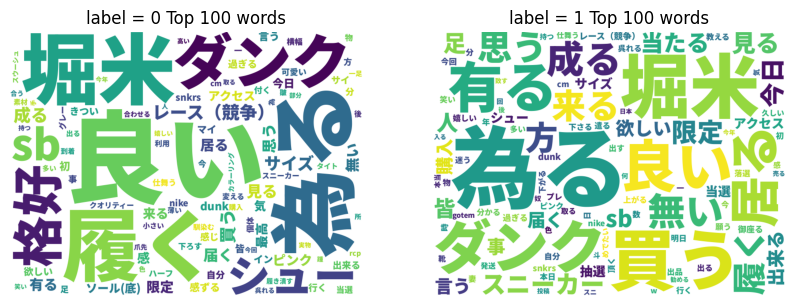

In [36]:
#それぞれのラベルごとの単語頻度を可視化する
fig, ax = plt.subplots(1,2, figsize=(10,20))

for label in pre_df.判断ラベル.unique():
  target_df = pre_df[pre_df.判断ラベル==label]
  word_freq = word_count(target_df.コメント)
  cloud = wordcloud.WordCloud(font_path="NotoSansJP-Black.ttf", background_color='white', width=800, height=600, max_words=100).generate_from_frequencies(word_freq)
  ax[label].imshow(cloud)
  ax[label].axis('off')
  ax[label].set_title("label = {} Top 100 words".format(label))

plt.show()


In [37]:
#TF-IDFによってそれぞれのコメントをベクトル化
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(pre_df.コメント)
print(tfidf.get_feature_names_out())

print(vector.shape)

['abcmart' 'adidas' 'adifom' ... 'ｴｪ' 'ｶﾝﾊﾟｰｲ' 'ﾟワイ']
(904, 2093)


In [44]:
df_X = vector
df_Y = pre_df.判断ラベル

print(df_X.shape, df_Y.shape)

(904, 2093) (904,)


In [45]:
#訓練データと評価データに分割
train_X, test_X, train_Y, test_Y = train_test_split(df_X, df_Y, test_size=0.3, random_state=9)

print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(632, 2093) (632,)
(272, 2093) (272,)


In [46]:
#SVMによるラベル分類
model = GridSearchCV(SVC(probability=True), param_grid={
    "kernel":["rbf", "poly", "linear"],}, n_jobs=3,)

model.fit(train_X, train_Y)

GridSearchCV(estimator=SVC(probability=True), n_jobs=3,
             param_grid={'kernel': ['rbf', 'poly', 'linear']})

In [47]:
print(model.best_estimator_)
print(model.best_score_)
print(model.best_params_)

SVC(kernel='linear', probability=True)
0.8481439820022496
{'kernel': 'linear'}


In [42]:
test_Y.value_counts().sum()

272

In [49]:
#学習したモデル評価データのラベル分類
from sklearn.metrics import confusion_matrix

pred_Y = model.predict(test_X)
cm = confusion_matrix(test_Y, pred_Y)

print(cm)

[[ 29  32]
 [  3 208]]


In [56]:

# 正解率 マクロ適合率 マクロ再現率 マクロF値
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

AC = np.array([cm[i,i] for i in range(len(cm))])
correct = np.sum(AC) / test_Y.value_counts().sum()
print("正解率:{:.3f}".format(correct))

precisions = np.zeros(len(cm)) # 適合率
recals = np.zeros(len(cm)) # 再現率
Fs = np.zeros(len(cm)) # F値
Accs = np.zeros(len(cm))

tps = np.zeros(len(cm)) # 真陽性
fps = np.zeros(len(cm)) # 真陰性
tns = np.zeros(len(cm)) # 偽陽性
fns = np.zeros(len(cm)) # 偽陰性

for i in range(len(cm)):
  tps[i] += cm[i,i]
  fps[i] += np.delete(np.delete(cm,i,0),i,1).sum()
  tns[i] += np.delete(cm[:,i],i,0)
  fns[i] += np.delete(cm[i,:],i,0).sum()

print(tps, fps, tns, fns)

for i in range(len(cm)):
  Accs[i] += (tps[i]+fps[i]) / (tps[i]+fps[i]+tns[i]+fns[i])
  recals[i] += tps[i] / (tps[i]+fns[i])
  precisions[i] += tps[i] / (tps[i]+tns[i])
  Fs[i] = 2*recals[i]*precisions[i] / (recals[i]+precisions[i])

print(Accs, recals, precisions, Fs)

正解率:0.871
[ 29. 208.] [208.  29.] [ 3. 32.] [32.  3.]
[0.87132353 0.87132353] [0.47540984 0.98578199] [0.90625    0.86666667] [0.62365591 0.92239468]


<ipython-input-56-c75d1cca3d6d>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tns[i] += np.delete(cm[:,i],i,0)


In [52]:
from sklearn.metrics import classification_report

label_name = df.判断ラベル.unique()
print(label_name)

print(classification_report(test_Y, pred_Y))

[0 1 2]
              precision    recall  f1-score   support

           0       0.91      0.48      0.62        61
           1       0.87      0.99      0.92       211

    accuracy                           0.87       272
   macro avg       0.89      0.73      0.77       272
weighted avg       0.88      0.87      0.86       272

